In [1]:
import pandas as pd
import numpy as np
import sys, os, glob
import matplotlib.pyplot as plt
from PIL import Image

import tqdm
import dlib         # 机器学习的库 Dlib
import numpy as np  # 数据处理的库 numpy
import cv2          # 图像处理的库 OpenCv
import time
import timeit

#### extract 68 landmarks by dlib

In [2]:
img_dir = '../dataBP4D/Images'
label_dir=  '../dataBP4D/label_real.csv'
df = pd.read_csv(label_dir)
del df['ID'], df['expression'], df['task'], df['frame_no'], df['exist']
extra_cols = []
for i in range(68):
    extra_cols.append("py%02d" % i)
    df[extra_cols[-1]] = None
    extra_cols.append("px%02d" % i)
    df[extra_cols[-1]] = None
df.set_index(keys=['path'], append=False, drop=True, inplace=True)
df.head()

,subject,AU01,AU02,AU04,AU06,AU07,AU10,AU12,AU14,AU15,...,py63,px63,py64,px64,py65,px65,py66,px66,py67,px67
path,,,,,,,,,,,,,,,,,,,,,
M006/T5/0647.jpg,M006,0,0,0,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None
M006/T5/0648.jpg,M006,0,0,0,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None
M006/T5/0649.jpg,M006,0,0,0,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None
M006/T5/0650.jpg,M006,0,0,0,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None
M006/T5/0651.jpg,M006,0,0,0,0,0,0,0,1,0,...,None,None,None,None,None,None,None,None,None,None


In [3]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor('../../shape_predictor_68_face_landmarks.dat')

In [5]:
def detectLandmarks(img):
    img_gray = np.array(img.convert('L'))
    faces = face_detector(img_gray, 0)
    if faces.__len__()>0: 
        landmarks = np.array([[p.x, p.y] for p in landmark_detector(np.array(img), faces[0]).parts()])
    else: landmarks = None
    return np.array(img), landmarks
def showImgLandmarks(img, landmarks=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    if landmarks is not None:
        ax.scatter(landmarks[:,0], landmarks[...,1])
        for i in range(landmarks.shape[0]):
            ax.text(landmarks[i,0], landmarks[i,1], i)
    plt.show()

In [6]:
import pickle
failure = []
for i, img_path in tqdm.tqdm_notebook(enumerate(df.index)):
    img = Image.open(os.path.join(img_dir, img_path))
    img, landmarks = detectLandmarks(img)
    if landmarks is None: 
        failure.append(img_path)
        continue
    #showImgLandmarks(img, landmarks)
    landmarks = landmarks[..., [1,0]].ravel()
    if not os.path.exists(os.path.join('./tmp', img_path[:-9])):
        os.makedirs(os.path.join('./tmp', img_path[:-9]))
    with open(os.path.join('./tmp', img_path[:-4])+'.pkl', 'wb') as f:
        pickle.dump(landmarks, f)


In [7]:
with open('./bp4d_failure.pkl', 'wb') as f:
    pickle.dump(failure, f)
len(failure)

7633

In [8]:
all_landmarks = []
for i, img_path in tqdm.tqdm_notebook(enumerate(df.index)):
    if os.path.exists(os.path.join('./tmp', img_path[:-4])+'.pkl'):
        with open(os.path.join('./tmp', img_path[:-4])+'.pkl', 'rb') as f:
            landmarks = pickle.load(f)
            all_landmarks.append(landmarks)
all_landmarks = np.stack(all_landmarks, axis=0)
all_landmarks.shape

(138940, 136)

In [9]:
tmp = df.copy()
tmp = tmp.drop(axis=0, index=failure)
tmp.shape

(138940, 149)

In [10]:
for i in range(68):
    tmp['py%02d'%i] = all_landmarks[:, i*2]
    tmp['px%02d'%i] = all_landmarks[:, i*2+1]

In [11]:
tmp.head()

,subject,AU01,AU02,AU04,AU06,AU07,AU10,AU12,AU14,AU15,...,py63,px63,py64,px64,py65,px65,py66,px66,py67,px67
path,,,,,,,,,,,,,,,,,,,,,
M006/T5/0647.jpg,M006,0,0,0,0,0,0,0,1,0,...,82,59,84,70,84,59,84,52,84,45
M006/T5/0648.jpg,M006,0,0,0,0,0,0,0,1,0,...,83,59,85,70,84,59,84,52,84,45
M006/T5/0649.jpg,M006,0,0,0,0,0,0,0,1,0,...,83,58,85,69,81,58,81,51,81,45
M006/T5/0650.jpg,M006,0,0,0,0,0,0,0,1,0,...,82,58,84,70,83,59,84,52,84,46
M006/T5/0651.jpg,M006,0,0,0,0,0,0,0,1,0,...,82,59,84,69,82,59,83,52,82,46


In [12]:
tmp.to_csv('./label_withLandmarks68.csv', index=True)

#### extract 24 landmarks according to 68 landmarks

In [13]:
def average_point(num1, num2, rescale_arr):
    x1 = rescale_arr[num1*2-2]
    y1 = rescale_arr[num1*2-1]
    x2 = rescale_arr[num2*2-2]
    y2 = rescale_arr[num2*2-1]
    x = (x1+x2)/2
    y = (y1+y2)/2
    return x,y

landmarks = tmp.iloc[:, -136:].values
final_res = np.zeros([landmarks.shape[0], 48], np.int32)
idx = 0

point_num = 0
for i, land_mark in tqdm.tqdm_notebook(enumerate(landmarks)):
    rescale_arr = np.asarray(land_mark, np.float32)
    #collect reslt
    single = []
    #au1: 22, 23
    point = [19, 22, 23, 26,  39, 37, 44, 46, 28, 30, 49, 51, 53, 55, 59, 57]
    double_point = [
            [20, 38],
            [25, 45],
            [41, 42],
            [47, 48],
            [18, 59],
            [27, 57]
            ]
    for ele in point:
        single.append(rescale_arr[ele*2-2])
        single.append(rescale_arr[ele*2-1]) # 6 point

    for tmp_idx in range(0, 4):
        # denote 
        #single[tmp_idx*2+1] = single[tmp_idx*2+1] - 20
        single[tmp_idx*2+1] = single[tmp_idx*2+1] - 10 

    # refine 19, 26 idx = 0, 3
        single[0*2+1] = single[0*2+1] + 2 
        single[3*2+1] = single[3*2+1] + 2 

    for ele in double_point:
        x,y = average_point(ele[0], ele[1], rescale_arr)
        single.append(x)
        single.append(y) # 7 point

    single.append(rescale_arr[49*2-2]-16)
    single.append(rescale_arr[49*2-1]-16) # 15 point
    single.append(rescale_arr[55*2-2]+16)
    single.append(rescale_arr[55*2-1]-16) # 16 point
    point_num = len(single)/2


    result_arr = np.asarray(single, np.float32)
    scale_single = (result_arr) * 224  /256.0;
    rescale_single = scale_single + 0.5;
    rescale_single.astype(int)
    final_res[idx,:] = rescale_single
    #final_res[idx,:] = result_arr
    idx = idx + 1

In [14]:
df = tmp[tmp.columns[:-136]].copy()
for i in range(48):
    df['ptx%02d' % i] = final_res[:, i]

In [15]:
df.to_csv('./label_withLandmarks24.csv', index=True)
df.head()

,subject,AU01,AU02,AU04,AU06,AU07,AU10,AU12,AU14,AU15,...,ptx38,ptx39,ptx40,ptx41,ptx42,ptx43,ptx44,ptx45,ptx46,ptx47
path,,,,,,,,,,,,,,,,,,,,,
M006/T5/0647.jpg,M006,0,0,0,0,0,0,0,1,0,...,35,68,54,22,54,70,60,15,88,51
M006/T5/0648.jpg,M006,0,0,0,0,0,0,0,1,0,...,36,68,54,22,54,70,60,15,88,50
M006/T5/0649.jpg,M006,0,0,0,0,0,0,0,1,0,...,35,68,53,22,53,69,60,15,88,49
M006/T5/0650.jpg,M006,0,0,0,0,0,0,0,1,0,...,35,68,54,23,54,70,60,14,88,50
M006/T5/0651.jpg,M006,0,0,0,0,0,0,0,1,0,...,35,68,53,23,53,70,60,14,88,50


In [16]:
df.shape

(138940, 61)

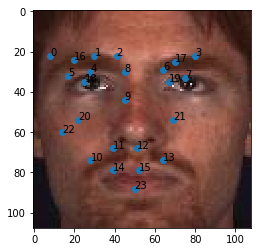

In [17]:
img = Image.open(os.path.join(img_dir, df.index[10]))
landmarks = df.iloc[10][-48:].values.reshape((-1,2))
landmarks = landmarks[:, [1,0]]
showImgLandmarks(np.array(img), landmarks)

#### offline occlusion
in fact, we use online occlusion

In [18]:
def addOcclusion(X):
    short = min(X.size)
    X = np.array(X)
    # (row, col)随机选取
    row = np.random.randint(X.shape[0]) 
    col = np.random.randint(X.shape[1])
    
    occ_size = short // 2

    # 随机选择一幅遮挡素材
    occ = occ_imgs[np.random.randint(0, len(occ_imgs))].copy()
    occ = occ.resize((occ_size, occ_size))
    occ = np.array(occ)

    # 在(row, col)处叠加遮挡素材
    row_begin = row - occ_size // 2
    col_begin = col - occ_size // 2
    row_begin = 0 if row_begin < 0 else row_begin
    col_begin = 0 if col_begin < 0 else col_begin
    patch = X[row_begin : (row_begin + occ_size), col_begin : (col_begin + occ_size), :]

    # 裁剪mask使得occ，使得occ和patch的shape完全相同
    occ = occ[:patch.shape[0], :patch.shape[1]]
    mask = occ[:, :, 3] > 150 #遮挡图像的白色区域不融合
    mask = np.expand_dims(mask, 2)
    mask = np.tile(mask, [1, 1, 3])

    temp = patch * (1 - mask) + occ[:, :, :3] * mask
    X[row_begin : row_begin + occ_size, col_begin : col_begin + occ_size, :] = temp
    X = Image.fromarray(X)
    return X

In [67]:
OCC_DIR = '../Occlusion Resource'
occ_imgs = [Image.open('/'.join([OCC_DIR, val])) for val in os.listdir(OCC_DIR)]
for val in tqdm.tqdm_notebook(df.index):
    X = Image.open(os.path.join(img_dir, val)).convert(mode='RGB')
    X = addOcclusion(X)
    if not os.path.exists('./OccImages/'+val[:-9]):
        os.makedirs('./OccImages/'+val[:-9])
    X.save(fp='./OccImages/'+val)